# W2.1 Perfilado y Limpieza de Datos

In [3]:
import os
from pathlib import Path
import json
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 160)

RAW_PATH = Path('data.csv')
PROCESSED_PATH = Path('/processed')
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

# Parte 1. Carga e inspección


In [4]:
if RAW_PATH.exists():
    df = pd.read_csv(RAW_PATH, encoding='ISO-8859-1')
    print(f"Cargado {RAW_PATH} -> shape: {df.shape}")
else:
    print(f"No se encontró {RAW_PATH}. Creando dataframe de ejemplo para demostración.")
    data = {
        'InvoiceNo': ['536365','536365','C536366','536367'],
        'StockCode': ['22833','85123A','84029G','23166'],
        'Description': ['SET OF 6 SPICE JARS','WHITE HANGING HEART T-LIGHT HOLDER','KNITTED UNION FLAG HOT WATER BOTTLE','JAM MAKING SET'],
        'Quantity': [6, 6, -1, 3],
        'InvoiceDate': ['2010-12-01 08:26','2010-12-01 08:26','2010-12-01 08:30','2010-12-01 09:00'],
        'UnitPrice': [2.55, 3.75, 3.39, 4.95],
        'CustomerID': [17850, 17850, np.nan, 13047],
        'Country': ['United Kingdom','United Kingdom','France','United Kingdom']
    }
    df = pd.DataFrame(data)

print('\nShape:', df.shape)
print('\nDtypes:')
print(df.dtypes)
print('\nPrimeras 5 filas:')
print(df.head())

Cargado data.csv -> shape: (541909, 8)

Shape: (541909, 8)

Dtypes:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Primeras 5 filas:
  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39

# Parte 1.2 - Asegurar tipos


In [5]:
if not np.issubdtype(df['InvoiceDate'].dtype, np.datetime64):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

numeric_cols = ['Quantity','UnitPrice']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

categorical_cols = ['InvoiceNo','StockCode','Description','Country','CustomerID']
for c in ['InvoiceNo','StockCode','Description','Country']:
    df[c] = df[c].astype('string')

try:
    df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce')
except Exception:
    pass

print('\nDtypes después de conversión:')
print(df.dtypes)



Dtypes después de conversión:
InvoiceNo      string[python]
StockCode      string[python]
Description    string[python]
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country        string[python]
dtype: object


# Parte 1.3 - Variables derivadas


In [6]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print('\nSe agregó TotalPrice. Ejemplo:')
print(df[['Quantity','UnitPrice','TotalPrice']].head())



Se agregó TotalPrice. Ejemplo:
   Quantity  UnitPrice  TotalPrice
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34


# Parte 1.4 - Distribuciones (gráficas)


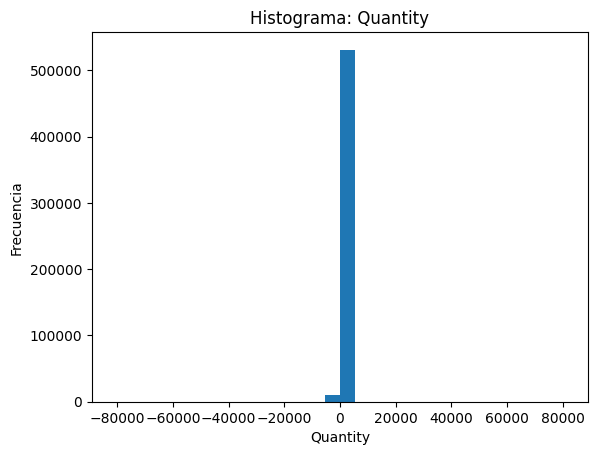

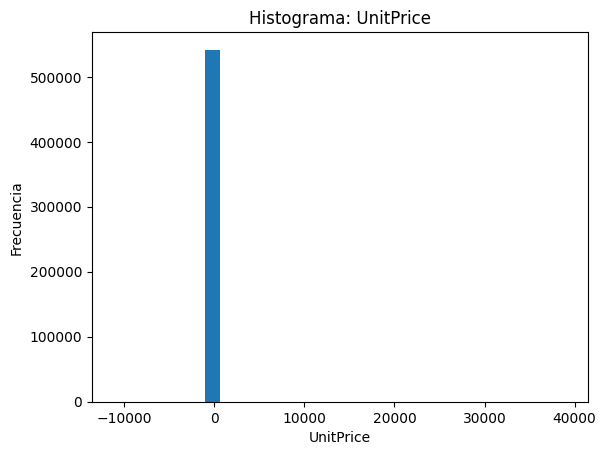

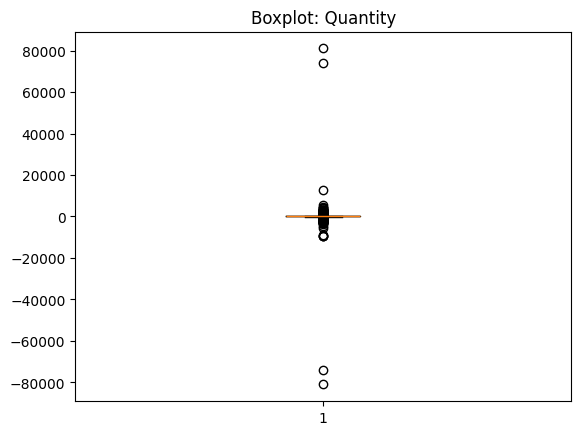

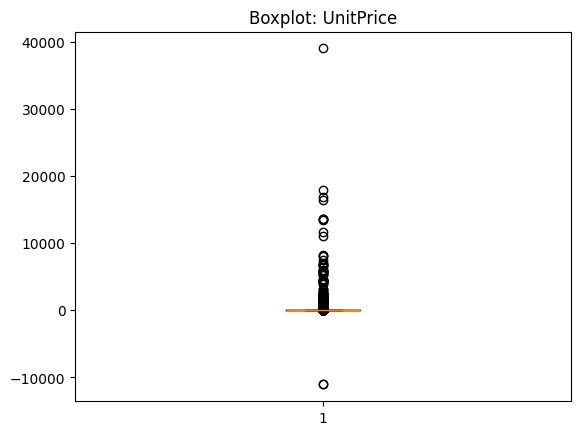

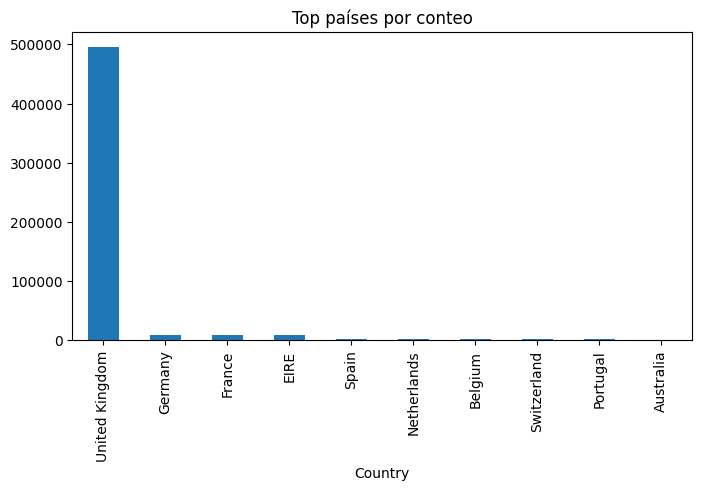

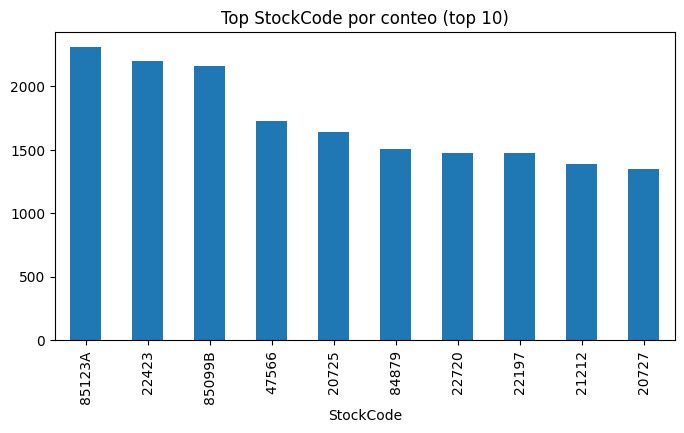

In [7]:
plt.figure()
plt.hist(df['Quantity'].dropna(), bins=30)
plt.title('Histograma: Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frecuencia')
plt.show()

plt.figure()
plt.hist(df['UnitPrice'].dropna(), bins=30)
plt.title('Histograma: UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Frecuencia')
plt.show()

# Boxplots
plt.figure()
plt.boxplot(df['Quantity'].dropna())
plt.title('Boxplot: Quantity')
plt.show()

plt.figure()
plt.boxplot(df['UnitPrice'].dropna())
plt.title('Boxplot: UnitPrice')
plt.show()

# Barras para las categorías más frecuentes
plt.figure(figsize=(8,4))
ax = df['Country'].value_counts().head(10).plot(kind='bar')
ax.set_title('Top países por conteo')
plt.show()

plt.figure(figsize=(8,4))
ax = df['StockCode'].value_counts().head(10).plot(kind='bar')
ax.set_title('Top StockCode por conteo (top 10)')
plt.show()


# Parte 2. Perfilado de Calidad
# 2.1 Nulos (por columna)

In [8]:

nulls = pd.DataFrame({'n_nulls': df.isna().sum(), 'pct_nulls': df.isna().mean() * 100})
print('\nNulos por columna:')
print(nulls)




Nulos por columna:
             n_nulls  pct_nulls
InvoiceNo          0   0.000000
StockCode          0   0.000000
Description     1454   0.268311
Quantity           0   0.000000
InvoiceDate        0   0.000000
UnitPrice          0   0.000000
CustomerID    135080  24.926694
Country            0   0.000000
TotalPrice         0   0.000000


# 2.2 Duplicados exactos


In [9]:
exact_dup_count = df.duplicated(keep=False).sum()
exact_dup_count_first = df.duplicated().sum()
print(f"\nDuplicados exactos (total marcados): {exact_dup_count}, duplicados conservando primera aparición: {exact_dup_count_first}")

if exact_dup_count_first > 0:
    print(df[df.duplicated(keep=False)].head())

# 2.3 Outliers para Quantity y UnitPrice usando IQR
def detect_iqr_outliers(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return s[(s < lower) | (s > upper)], lower, upper

out_q, q_lower, q_upper = detect_iqr_outliers(df['Quantity'].dropna())
out_p, p_lower, p_upper = detect_iqr_outliers(df['UnitPrice'].dropna())
print(f"\nQuantity outliers count: {out_q.shape[0]} (bounds {q_lower}, {q_upper})")
print(f"UnitPrice outliers count: {out_p.shape[0]} (bounds {p_lower}, {p_upper})")


# Parte 3. Limpieza
original_shape = df.shape

# 3.1 Duplicados exactos - antes/después
count_exact_before = df.shape[0]
count_exact_dup = df.duplicated().sum()
print(f"\nFilas antes: {count_exact_before}, duplicados exactos (a eliminar): {count_exact_dup}")

df_clean = df.drop_duplicates(keep='first').copy()
count_exact_after = df_clean.shape[0]
print(f"Filas después de drop_duplicates: {count_exact_after}")

key_cols = ['InvoiceNo','StockCode','InvoiceDate']
dup_by_key_before = df.shape[0] - df.drop_duplicates(subset=key_cols).shape[0]
print(f"\nDuplicados por clave {key_cols}: {dup_by_key_before}")


order_cols = ['InvoiceDate']
df_key_sorted = df.sort_values(by=['InvoiceDate'], ascending=True)


df_key_resolved = df_key_sorted.drop_duplicates(subset=key_cols, keep='first').copy()
print(f"Filas después de resolver duplicados por clave: {df_key_resolved.shape[0]}")

# 3.2 Valores faltantes - CustomerID
missing_customer_count = df['CustomerID'].isna().sum()
pct_missing_customer = df['CustomerID'].isna().mean() * 100
print(f"\nCustomerID missing: {missing_customer_count} rows ({pct_missing_customer:.2f}%)")

rows_if_drop = df.dropna(subset=['CustomerID']).shape[0]
print(f"Filas si eliminamos sin CustomerID: {rows_if_drop} (se eliminarían {df.shape[0]-rows_if_drop})")


df_final = df.copy()
df_final = df_final.drop_duplicates(keep='first')
if 'Quantity' in df_final.columns:
    zero_q = (df_final['Quantity'] == 0).sum()
    print(f"Filas con Quantity==0: {zero_q}")
    df_final = df_final[df_final['Quantity'] != 0]
if 'UnitPrice' in df_final.columns:
    nonpos = (df_final['UnitPrice'] <= 0).sum()
    print(f"Filas con UnitPrice <= 0: {nonpos}")
    df_final = df_final[df_final['UnitPrice'] > 0]

print(f"\nShape original: {original_shape}, shape final: {df_final.shape}")


# Parte 4. Data Contract (JSON + YAML)
contract = {
    'name': 'online_retail_II_min_contract',
    'version': '1.0',
    'description': 'Data contract mínimo para columnas clave del dataset Online Retail II',
    'columns': {
        'InvoiceNo': {
            'type': 'string',
            'nullable': False,
            'unique': False,
            'notes': 'Identificador de factura. Prefijo C indica cancelación/credit note.'
        },
        'InvoiceDate': {
            'type': 'datetime',
            'nullable': False,
            'format': 'YYYY-MM-DD HH:MM:SS',
            'notes': 'Fecha y hora de la transacción'
        },
        'StockCode': {
            'type': 'string',
            'nullable': False,
            'notes': 'Código del producto'
        },
        'Description': {
            'type': 'string',
            'nullable': True,
            'notes': 'Descripción del producto; puede tener NaNs'
        },
        'Quantity': {
            'type': 'integer',
            'nullable': False,
            'min_value': -999999,
            'notes': 'Cantidad; valores negativos representan devoluciones'
        },
        'UnitPrice': {
            'type': 'float',
            'nullable': False,
            'min_value': 0.0,
            'notes': 'Precio por unidad en GBP'
        },
        'CustomerID': {
            'type': 'integer',
            'nullable': True,
            'notes': 'Identificador de cliente; puede faltar para transacciones anónimas'
        }
    },
    'row_level': {
        'max_columns': 50
    },
    'checks': [
        {'check': 'no_null', 'columns': ['InvoiceNo','InvoiceDate','StockCode','Quantity','UnitPrice']},
        {'check': 'unitprice_positive', 'columns': ['UnitPrice']},
        {'check': 'quantity_nonzero_or_negative_allowed', 'columns': ['Quantity']}
    ]
}

with open(PROCESSED_PATH / 'data_contract.json', 'w', encoding='utf-8') as f:
    json.dump(contract, f, indent=2)

with open(PROCESSED_PATH / 'data_contract.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(contract, f, sort_keys=False, allow_unicode=True)

print(f"Data contract guardado en {PROCESSED_PATH}")


# Parte 5. Conclusiones - resumen antes/después (tabla breve)
summary = pd.DataFrame([
    {'item': 'rows_before', 'value': original_shape[0]},
    {'item': 'cols_before', 'value': original_shape[1]},
    {'item': 'rows_after_clean', 'value': df_final.shape[0]},
    {'item': 'cols_after_clean', 'value': df_final.shape[1]},
    {'item': 'exact_duplicates_removed', 'value': count_exact_dup},
    {'item': 'customerid_missing_pct', 'value': pct_missing_customer}
])




Duplicados exactos (total marcados): 10147, duplicados conservando primera aparición: 5268
    InvoiceNo StockCode                       Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice
485    536409     22111      SCOTTIE DOG HOT WATER BOTTLE         1 2010-12-01 11:45:00       4.95     17908.0  United Kingdom        4.95
489    536409     22866     HAND WARMER SCOTTY DOG DESIGN         1 2010-12-01 11:45:00       2.10     17908.0  United Kingdom        2.10
494    536409     21866       UNION JACK FLAG LUGGAGE TAG         1 2010-12-01 11:45:00       1.25     17908.0  United Kingdom        1.25
517    536409     21866       UNION JACK FLAG LUGGAGE TAG         1 2010-12-01 11:45:00       1.25     17908.0  United Kingdom        1.25
521    536409     22900   SET 2 TEA TOWELS I LOVE LONDON          1 2010-12-01 11:45:00       2.95     17908.0  United Kingdom        2.95

Quantity outliers count: 58619 (bounds -12.5, 23.5)
UnitPrice outliers co